<a href="https://colab.research.google.com/github/KaushikPalani/Classification_of_bearing_faults_using_ML/blob/main/ClassificationModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


Load necessary packages and libraries 

In [ ]:
import scipy.io 
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd



Import Data  

In [ ]:
def ImportData():
  X99_normal = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time']              
  X111_InnerRace_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/111.mat')['X111_DE_time']
  X124_Ball_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/124.mat')['X124_DE_time']
  X137_Outer_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/137.mat')['X137_DE_time']
  X176_InnerRace_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/176.mat')['X176_DE_time']
  X191_Ball_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/191.mat')['X191_DE_time']
  X203_Outer_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/203.mat')['X203_DE_time']
  X215_InnerRace_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/215.mat')['X215_DE_time']
  X228_Ball_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/228.mat')['X228_DE_time']
  X240_Outer_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/240.mat')['X240_DE_time']
  return [X99_normal,X111_InnerRace_007,X124_Ball_007,X137_Outer_007,X176_InnerRace_014,X191_Ball_014,X203_Outer_014,X215_InnerRace_021,X228_Ball_021,X240_Outer_021]


def Sampling(Data, interval_length, samples_per_block):
  # Calculate the number of blocks that can be sampled based on the interval length 
  No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length)-1)
  SplitData = np.zeros([No_of_blocks, samples_per_block])
  for i in range(No_of_blocks):
    SplitData[i,:] = (Data[i*interval_length:(i*interval_length)+samples_per_block]).T
  return SplitData


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block)
    y = np.zeros([len(SplitData),10])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1])
    y1[:,0] = count
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  return X, LabelPositional, Label


Data = ImportData()
interval_length = 200  
samples_per_block = 1681


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

Shape of Input Data = (24276, 1681)
Shape of Label Y_CNN = (24276, 10)
Shape of Label Y = (24276, 1)


Export Input Data to MATLAB


*   For feature Extraction - time and frequency domain analysis  
*   For implementing Self Organizing Feature Maps using MATLAB 'nctool' feature



In [ ]:
XX = {'X':X}
scipy.io.savemat('Data.mat', XX)

K-Fold Cross Validation 

In [ ]:
# k-fold cross validation 
kSplits = 5
kfold = KFold(n_splits=kSplits, random_state=32, shuffle=True)

**NEURAL NETWORK MODELS**

**1-Dimensional Convolutional Neural Network Classification**

In [ ]:
# Reshape the data - 1 dimensional feed 
Input_1D = X.reshape([-1,1681,1])

# Test-Train Split 
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class CNN_1D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Flatten(),
        layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_1D = []

# Train the model 
for train, test in kfold.split(X_1D_train,y_1D_train):
  Classification_1D = CNN_1D()
  history = Classification_1D.model.fit(X_1D_train[train], y_1D_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set 
  kf_loss, kf_accuracy = Classification_1D.model.evaluate(X_1D_train[test], y_1D_train[test]) 
  accuracy_1D.append(kf_accuracy)

CNN_1D_train_accuracy = np.average(accuracy_1D)*100
print('CNN 1D train accuracy =', CNN_1D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_1D_test_loss, CNN_1D_test_accuracy = Classification_1D.model.evaluate(X_1D_test, y_1D_test)
CNN_1D_test_accuracy*=100
print('CNN 1D test accuracy =', CNN_1D_test_accuracy)



Epoch 1/12
456/456 [==============================] - 16s 32ms/step - loss: 0.7933 - accuracy: 0.6835
Epoch 2/12
456/456 [==============================] - 12s 26ms/step - loss: 0.4144 - accuracy: 0.8154
Epoch 3/12
456/456 [==============================] - 12s 25ms/step - loss: 0.2757 - accuracy: 0.8793
Epoch 4/12
456/456 [==============================] - 12s 25ms/step - loss: 0.1309 - accuracy: 0.9503
Epoch 5/12
456/456 [==============================] - 12s 26ms/step - loss: 0.0804 - accuracy: 0.9702
Epoch 6/12
456/456 [==============================] - 12s 26ms/step - loss: 0.0589 - accuracy: 0.9782
Epoch 7/12
456/456 [==============================] - 12s 25ms/step - loss: 0.0473 - accuracy: 0.9828
Epoch 8/12
456/456 [==============================] - 12s 25ms/step - loss: 0.0462 - accuracy: 0.9829
Epoch 9/12
456/456 [==============================] - 12s 25ms/step - loss: 0.0274 - accuracy: 0.9900
Epoch 10/12
456/456 [==============================] - 12s 25ms/step - loss: 0.052

Confusion Matrix Calculation

In [ ]:
def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

Plot results - CNN 1D

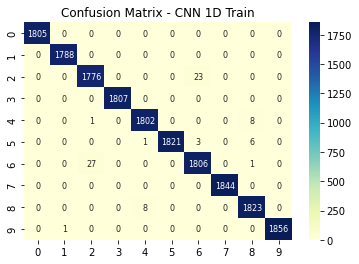

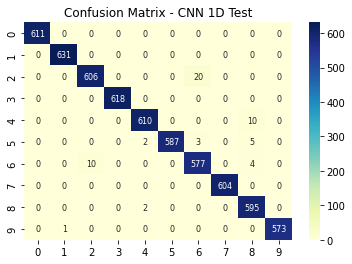

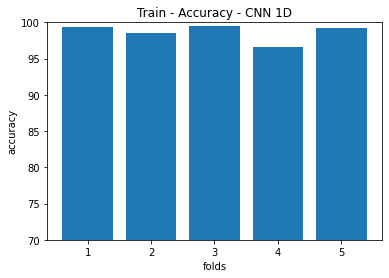

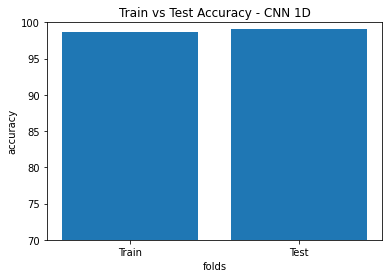

In [ ]:
plt.figure(1)
plt.title('Confusion Matrix - CNN 1D Train') 
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_train, y_1D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(2)
plt.title('Confusion Matrix - CNN 1D Test') 
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_test, y_1D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(3)
plt.title('Train - Accuracy - CNN 1D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_1D])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(4)
plt.title('Train vs Test Accuracy - CNN 1D')
plt.bar([1,2],[CNN_1D_train_accuracy,CNN_1D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

**2-Dimensional Convolutional Neural Network Classification**

In [ ]:
# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,41,41,1])

# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3),strides=(2,2), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_2D = []

# Train the model 
for train, test in kfold.split(X_2D_train,y_2D_train):
  Classification_2D = CNN_2D()
  history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set 
  kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_2D.append(kf_accuracy)

CNN_2D_train_accuracy = np.average(accuracy_2D)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
CNN_2D_test_accuracy*=100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)



Epoch 1/12
456/456 [==============================] - 7s 14ms/step - loss: 0.8788 - accuracy: 0.6512
Epoch 2/12
456/456 [==============================] - 6s 14ms/step - loss: 0.3642 - accuracy: 0.8499
Epoch 3/12
456/456 [==============================] - 6s 14ms/step - loss: 0.2963 - accuracy: 0.8755
Epoch 4/12
456/456 [==============================] - 6s 14ms/step - loss: 0.2663 - accuracy: 0.8870
Epoch 5/12
456/456 [==============================] - 6s 14ms/step - loss: 0.2312 - accuracy: 0.9020
Epoch 6/12
456/456 [==============================] - 6s 14ms/step - loss: 0.2061 - accuracy: 0.9145
Epoch 7/12
456/456 [==============================] - 6s 14ms/step - loss: 0.1821 - accuracy: 0.9269
Epoch 8/12
456/456 [==============================] - 6s 14ms/step - loss: 0.1305 - accuracy: 0.9513
Epoch 9/12
456/456 [==============================] - 6s 14ms/step - loss: 0.1035 - accuracy: 0.9616
Epoch 10/12
456/456 [==============================] - 6s 14ms/step - loss: 0.0872 - accura

Plot results - CNN 2D

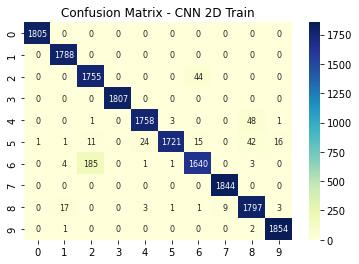

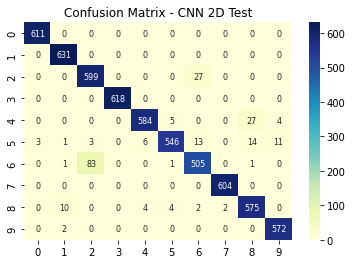

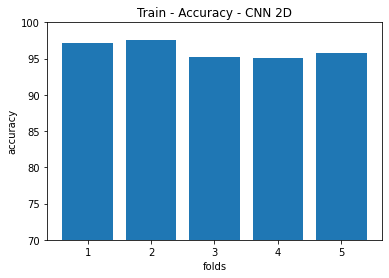

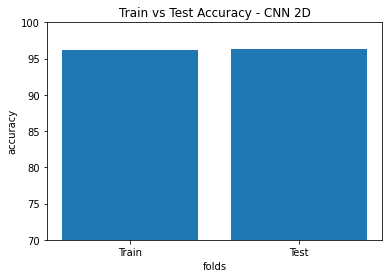

In [ ]:
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(Classification_2D, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(Classification_2D, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_2D])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

**Long Short-Term Memory Recurrent Neural Network Classification Model** 

In [ ]:
# Reshape the data - 1 dimensional feed 
Input = X.reshape([-1,1681,1])

# Test-Train Split 
X_train, X_test, y_train, y_test = train_test_split(Input, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the LSTM Classification model
class LSTM_Model():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.LSTM(32, return_sequences=True),
        layers.Flatten(),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy = []

# Train the model 
for train, test in kfold.split(X_train,y_train):
  Classification = LSTM_Model()
  history = Classification.model.fit(X_train[train], y_train[train], verbose=1, epochs=10, use_multiprocessing=True)

  # Evaluate the accuracy of the model on the training set 
  kf_loss, kf_accuracy = Classification.model.evaluate(X_train[test], y_train[test]) 
  accuracy.append(kf_accuracy)

LSTM_train_accuracy = np.average(accuracy)*100
print('LSTM train accuracy =', LSTM_train_accuracy)


# Evaluate the accuracy of the model on the test set
LSTM_test_loss, LSTM_test_accuracy = Classification.model.evaluate(X_test, y_test)
LSTM_test_accuracy*=100
print('LSTM test accuracy =', LSTM_test_accuracy)



Epoch 1/10
456/456 [==============================] - 280s 609ms/step - loss: 1.1866 - accuracy: 0.5649
Epoch 2/10
456/456 [==============================] - 279s 612ms/step - loss: 0.3088 - accuracy: 0.8880
Epoch 3/10
456/456 [==============================] - 280s 613ms/step - loss: 0.2035 - accuracy: 0.9286
Epoch 4/10
456/456 [==============================] - 278s 609ms/step - loss: 0.1696 - accuracy: 0.9393
Epoch 5/10
456/456 [==============================] - 278s 610ms/step - loss: 0.1414 - accuracy: 0.9508
Epoch 6/10
456/456 [==============================] - 278s 609ms/step - loss: 0.1144 - accuracy: 0.9603
Epoch 7/10
456/456 [==============================] - 276s 606ms/step - loss: 0.1216 - accuracy: 0.9640
Epoch 8/10
456/456 [==============================] - 277s 608ms/step - loss: 0.1041 - accuracy: 0.9676
Epoch 9/10
456/456 [==============================] - 278s 610ms/step - loss: 0.0700 - accuracy: 0.9789
Epoch 10/10
114/114 [==============================] - 15s 129ms

Plot results - LSTM Model

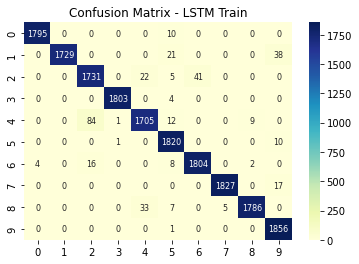

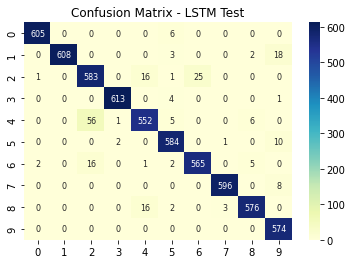

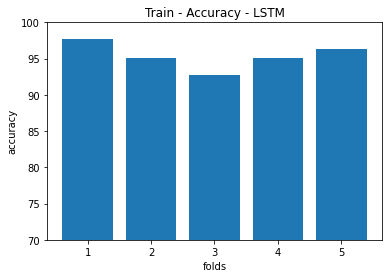

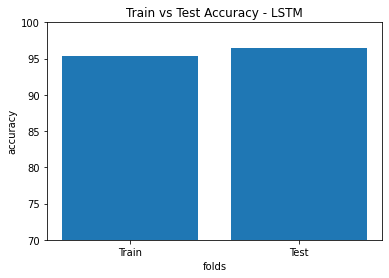

In [ ]:

plt.figure(9)
plt.title('Confusion Matrix - LSTM Train') 
sns.heatmap(ConfusionMatrix(Classification, X_train, y_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(10)
plt.title('Confusion Matrix - LSTM Test') 
sns.heatmap(ConfusionMatrix(Classification, X_test, y_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(11)
plt.title('Train - Accuracy - LSTM')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(12)
plt.title('Train vs Test Accuracy - LSTM')
plt.bar([1,2],[LSTM_train_accuracy,LSTM_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()



**SUPPORT VECTOR MACHINE MODEL** 

Import Feature Data


*   The input data has been pre processed in MATLAB to extract the features like max, min, peak-to-peak, mean, variance, standard deviation, root-mean-square, skewness, crest factor, kurtosis in time domain, and amplitude and value of the maximum frequency in the frequency domains.






In [ ]:
X_Features = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/X_Features.mat')['Feature_Data']

# Feature data shape (no. of samples, no. of features)
X_Features.shape


(24276, 12)

Import packages and dependencies 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm 
import warnings 
warnings.filterwarnings('ignore')

Normalize the Input Data

In [ ]:
X_Norm = StandardScaler().fit_transform(X_Features)

Dimensionality Reduction - Principal Component Analysis 

In [ ]:
pca = PCA(n_components=5)
Input_SVM_np = pca.fit_transform(X_Norm)
Input_SVM = pd.DataFrame(data = Input_SVM_np)
Label_SVM = pd.DataFrame(Y, columns = ['target'])

Train the Model

In [ ]:
# Test-Train Split 
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(Input_SVM_np, Y, train_size=0.75,test_size=0.25, random_state=101)

# Support vector Machine - radial basis function kernel
rbf = SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo')


accuracy_SVM = []

# Train the model 
for train, test in kfold.split(X_train_SVM, y_train_SVM):
  history = rbf.fit(X_train_SVM[train], y_train_SVM[train])

  # Evaluate the accuracy of the model on the training set 
  kf_accuracy = rbf.score(X_train_SVM[test], y_train_SVM[test]) 
  accuracy_SVM.append(kf_accuracy)

SVM_train_accuracy = np.average(accuracy_SVM)*100
print('SVM train accuracy =', SVM_train_accuracy)


# Evaluate the accuracy of the model on the test set
SVM_test_accuracy = rbf.score(X_test_SVM, y_test_SVM) 
SVM_test_accuracy*=100
print('SVM test accuracy =', SVM_test_accuracy)



SVM train accuracy = 92.82141985059111
SVM test accuracy = 92.45345196902291


Plot results - SVM

0.9350799143186687


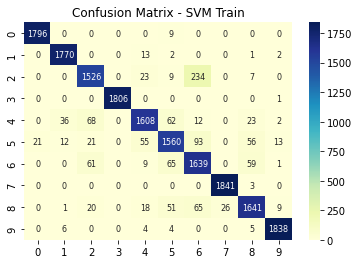

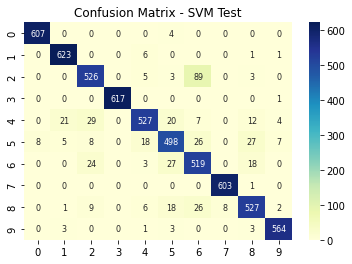

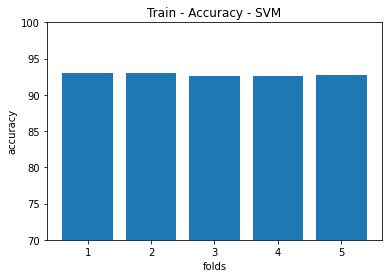

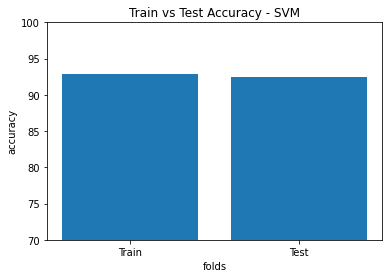

In [ ]:
def ConfusionMatrix_SVM(Model, X, y):
  y_pred = Model.predict(X)
  ConfusionMat = confusion_matrix(y, y_pred)
  return ConfusionMat

print(rbf.score(X_train_SVM, y_train_SVM))

plt.figure(13)
plt.title('Confusion Matrix - SVM Train') 
sns.heatmap(ConfusionMatrix_SVM(rbf, X_train_SVM, y_train_SVM) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(14)
plt.title('Confusion Matrix - SVM Test') 
sns.heatmap(ConfusionMatrix_SVM(rbf, X_test_SVM, y_test_SVM) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(15)
plt.title('Train - Accuracy - SVM')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_SVM])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(16)
plt.title('Train vs Test Accuracy - SVM')
plt.bar([1,2],[SVM_train_accuracy,SVM_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

Plot Decision boundaries in 2D

<Figure size 432x288 with 0 Axes>

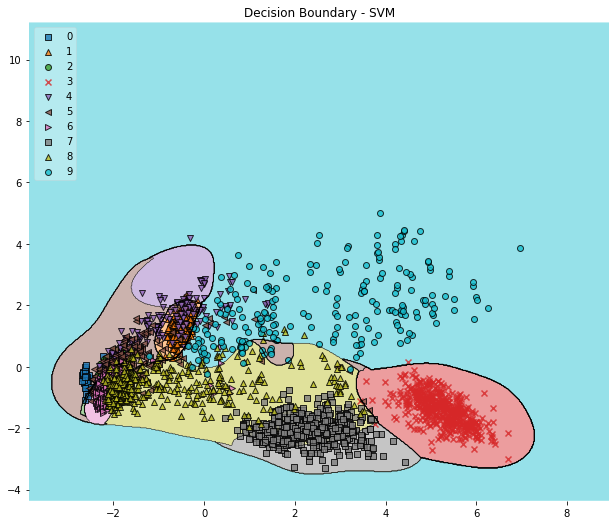

In [ ]:
from mlxtend.plotting import plot_decision_regions
value = 0
width = 1
plt.figure(17)
plt.figure(figsize=(10.4,8.8))
plt.title('Decision Boundary - SVM')
plot_decision_regions(X_test_SVM, (y_test_SVM.astype(np.integer)).flatten(), clf=rbf, legend=2,
                  feature_index=[0,1],
                  filler_feature_values={2:value, 3:value, 4:value},
                  filler_feature_ranges={2:width, 3:width, 4:width},)
plt.show()

**COMPARISON OF MODELS**

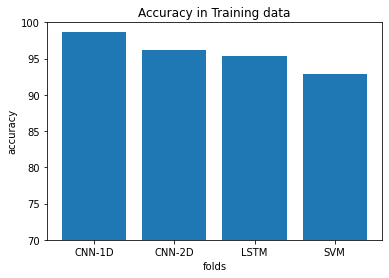

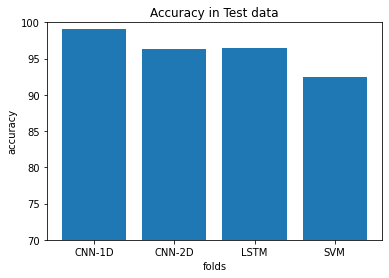

In [ ]:
plt.figure(18)
plt.title('Accuracy in Training data')
plt.bar([1,2,3,4],[CNN_1D_train_accuracy, CNN_2D_train_accuracy, LSTM_train_accuracy, SVM_train_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2,3,4],['CNN-1D', 'CNN-2D' , 'LSTM', 'SVM'])
plt.ylim([70,100])
plt.show()


plt.figure(19)
plt.title('Accuracy in Test data')
plt.bar([1,2,3,4],[CNN_1D_test_accuracy, CNN_2D_test_accuracy, LSTM_test_accuracy, SVM_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2,3,4],['CNN-1D', 'CNN-2D' , 'LSTM', 'SVM'])
plt.ylim([70,100])
plt.show()